In [11]:
!pip install transformers diffusers torch accelerate sentencepiece

In [12]:
import torch
from transformers import pipeline, set_seed, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [13]:
class TextGenerator:
    def __init__(self, model_name="EleutherAI/gpt-neo-1.3B"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            low_cpu_mem_usage=True,
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def generate_text(self, prompt, max_length=150, temperature=0.8, top_k=50, top_p=0.95):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        outputs = self.model.generate(
            inputs["input_ids"],
            max_length=max_length,
            temperature=temperature,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=self.tokenizer.eos_token_id,
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

In [14]:
# use "stable-diffusion-v1-5/stable-diffusion-v1-5" if in case runwayml doesn't work
class ImageGenerator:
    def __init__(self, model_name="runwayml/stable-diffusion-v1-5"):
        self.pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float32)
        self.pipe = self.pipe.to("cpu")

    def generate_image(self, prompt):
        """Generates an image based on the given prompt."""
        image = self.pipe(prompt).images[0]
        return image

In [15]:
class StoryGenerator:
    def __init__(self):
        self.text_gen = TextGenerator()
        self.image_gen = ImageGenerator()

    def generate_story(self, prompt):
        """
        Generates a balanced story and an image based on the given prompt.
        """
        story = self.text_gen.generate_text(prompt)
        image = self.image_gen.generate_image(prompt)
        return story, image

In [16]:
def display_story(story, image):
    """Displays the story and image."""
    print("Generated Story:")
    print(story)
    print("\nGenerated Image:")
    display(image)


# Initialize the story generator
story_gen = StoryGenerator()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated Story:
Once upon a time in a mystical forest, a young girl discovered a magical pendant. But the magic was lost when she was taken into the hands of the witch, who used it to create a magical monster.

For the next few years the girl became more and more desperate to get rid of the monster, until one day, she finally succeeded when she killed the witch with her own bare hands.

She became a witch, but was determined to stay a witch in the hope that she could use her magic to help others. She became a witch, but was determined to stay a witch in the hope that she could use her magic to help others.

However, her life as a witch was cut short when she was caught

Generated Image:


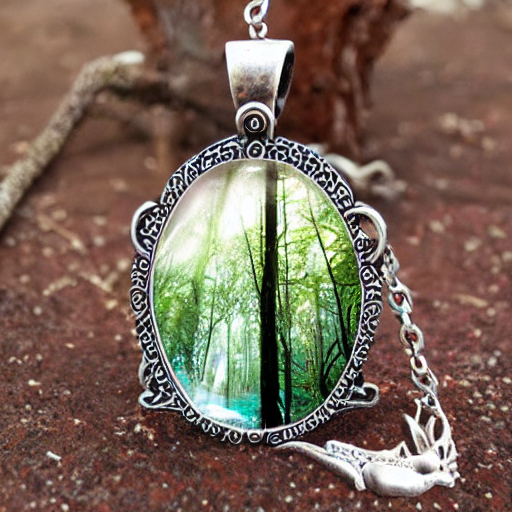

In [17]:
# Get user input
# user_prompt = input("Enter a prompt for your story: ")
user_prompt = "Once upon a time in a mystical forest, a young girl discovered a magical pendant."

# Generate story and image
generated_story, generated_image = story_gen.generate_story(user_prompt)

# Display the results
display_story(generated_story, generated_image)

In [18]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

class TextGenerator:
    def __init__(self, model_name="EleutherAI/gpt-neo-1.3B", model_dir="/content/gpt-neo"):
        self.model_dir = model_dir
        if os.path.exists(model_dir):
            print("Loading model from saved files...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
            self.model = AutoModelForCausalLM.from_pretrained(model_dir)
        else:
            print("Downloading and saving model...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                low_cpu_mem_usage=True,
            )
            # Save the model and tokenizer
            os.makedirs(model_dir, exist_ok=True)
            self.tokenizer.save_pretrained(model_dir)
            self.model.save_pretrained(model_dir)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    def preprocess_prompt(self, prompt):
        """Add ethical guidelines or context to the prompt."""
        guidelines = (
            "Write a meaningful, unbiased, and ethical story that promotes creativity "
            "and does not contain harmful or offensive content. "
        )
        return f"{guidelines}{prompt}"

    def generate_text(self, prompt, max_length=300, temperature=0.8, top_k=50, top_p=0.95):
        """Generate a story based on the given prompt."""
        processed_prompt = self.preprocess_prompt(prompt)
        inputs = self.tokenizer(processed_prompt, return_tensors="pt").to(self.device)
        outputs = self.model.generate(
            inputs["input_ids"],
            max_length=max_length,
            temperature=temperature,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=self.tokenizer.eos_token_id,
        )
        story = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return story

    def summarize_story(self, story, max_length=100, min_length=30):
        """Generate a summary for the story."""
        summary = self.summarizer(story, max_length=max_length, min_length=min_length, do_sample=False)
        return summary[0]['summary_text']

    def generate_summary(self, prompt):
        """Generate a story and return only the summary."""
        story = self.generate_text(prompt)
        summary = self.summarize_story(story)
        return summary

In [19]:
from diffusers import StableDiffusionPipeline

# use "stable-diffusion-v1-5/stable-diffusion-v1-5" if in case runwayml doesn't work
class ImageGenerator:
    def __init__(self, model_name="runwayml/stable-diffusion-v1-5", model_dir="/content/stable-diffusion"):
        self.model_dir = model_dir
        if not os.path.exists(model_dir):  # Check if the model is already saved
            print(f"Downloading and saving {model_name} to {model_dir}...")
            self.pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float32)
            self.pipe.save_pretrained(model_dir)
            print("Model saved!")
        else:
            print(f"Loading {model_name} from {model_dir}...")
            self.pipe = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float32)
        self.pipe = self.pipe.to("cpu")

    def generate_image(self, prompt):
        """Generates an image based on the given prompt."""
        image = self.pipe(prompt).images[0]
        return image

Loading model from saved files...


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Loading runwayml/stable-diffusion-v1-5 from /content/stable-diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated Story:
Write a meaningful, unbiased, and ethical story that promotes creativity and does not contain harmful or offensive content. Once upon a time in a mystical forest, a young girl discovered a magical pendant. The pendant contained a spell that could grant wishes and unlock magical abilities. When the girl opened the pendant, the spell was broken. She was reborn with a new body and a new magic, but she was alone in the forest.

The magical pendant was a great story for children to learn about the magic of the gods. However, the magical pendant was so powerful, it could make the forest inhospitable and the girl lost her magic. The girl wished she could return the magical pendant to its original location, but she could not. She wished to bring her magic back, but she could not. The only way to bring her magic back was for the magic to be returned to the girl. This was a story that could be told by a young girl who wished to bring back her magic.

The story of this magical pe

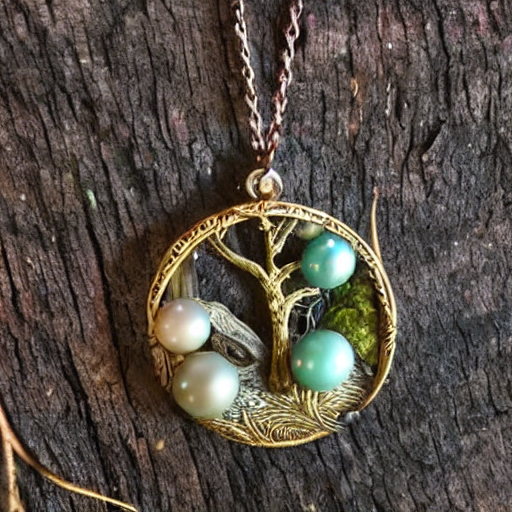

In [20]:
# Initialize with saved models
text_gen = TextGenerator(model_dir="/content/gpt-neo")
image_gen = ImageGenerator(model_dir="/content/stable-diffusion")

# Generate text and image for a prompt
prompt = "Once upon a time in a mystical forest, a young girl discovered a magical pendant."
story = text_gen.generate_text(prompt, max_length=300, temperature=0.8)
image = image_gen.generate_image(prompt)

# Display results
from IPython.display import display
print("Generated Story:")
print(story)
print("\nGenerated Image:")
display(image)

In [21]:
class StoryGenerator:
    def __init__(self):
        self.text_gen = TextGenerator(model_dir="/content/gpt-neo")
        self.image_gen = ImageGenerator(model_dir="/content/stable-diffusion")

    def generate_story(self, prompt):
        """
        Generates a balanced story and an image based on the given prompt.
        """
        story = self.text_gen.generate_text(prompt, max_length=300, temperature=0.8)
        image = self.image_gen.generate_image(prompt)
        return story, image

    @staticmethod
    def display_story(story, image):
        """Displays the story and image."""
        print("Generated Story:")
        print(story)
        print("\nGenerated Image:")
        display(image)

Loading model from saved files...


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Loading runwayml/stable-diffusion-v1-5 from /content/stable-diffusion...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated Story:
Write a meaningful, unbiased, and ethical story that promotes creativity and does not contain harmful or offensive content. In the year 3050, humans had colonized Mars, but something mysterious was happening on the red planet. In the year 3050, a mysterious disease began to kill off the inhabitants of Mars. In the year 3050, a group of scientists and explorers began an expedition to Mars to search for the cause of this strange disease. In the year 3050, a group of scientists and explorers began an expedition to Mars to search for the cause of this strange disease.

The story of the first expedition to Mars begins in the year 3050. In the year 3050, a mysterious disease began to kill off the inhabitants of Mars. In the year 3050, a group of scientists and explorers began an expedition to Mars to search for the cause of this strange disease. In the year 3050, a group of scientists and explorers began an expedition to Mars to search for the cause of this strange disease.


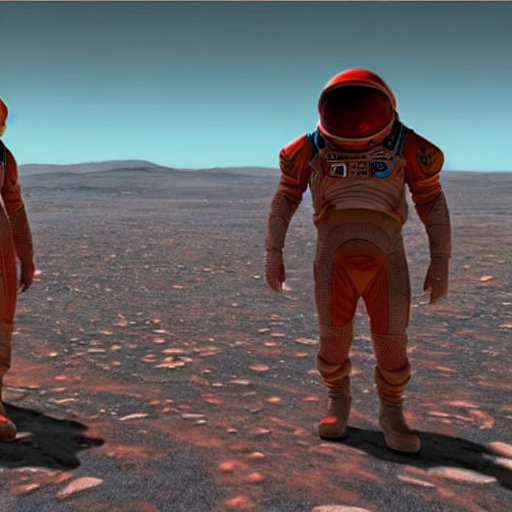

In [22]:
# Initialize the generator
story_gen = StoryGenerator()

# Provide a prompt
user_prompt = "In the year 3050, humans had colonized Mars, but something mysterious was happening on the red planet."

# Generate story and image
story, image = story_gen.generate_story(user_prompt)

# Display results
StoryGenerator.display_story(story, image)